In [1]:
import sys
print(sys.executable)
import numpy as np
from scipy.stats import rankdata, ttest_rel, ttest_1samp
from scipy.stats import zscore
from matplotlib import pyplot as plt
from scipy.stats import linregress


subjects =  ['sub-EZ9NM','sub-TV7EF','sub-WLC4O','sub-3L109','sub-3UYSS','sub-JVPPA','sub-EDOP8',
             'sub-TIJD1','sub-AYDLR','sub-98UT7','sub-4G9A5','sub-YJBI8','sub-FG8PD','sub-BBN4K',
             'sub-F61IR','sub-M1ZRL','sub-NZJZN','sub-XZ9SS','sub-L05R3','sub-ZOVPY','sub-6PEOF',
             'sub-G6RPG','sub-TPNCU','sub-9ADGJ','sub-27IXQ','sub-NDX5S','sub-OE7EZ','sub-28E84',
             'sub-ENN9N','sub-28OBV','sub-8WJAP','sub-SPHBN','sub-WP8SX','sub-BG4CW','sub-AVQEZ',
             'sub-YLWD1','sub-0A4MV','sub-8PIML','sub-4T7NM','sub-X5RE0','sub-RUQON','sub-JVT46',
             'sub-RTFX9','sub-OWWAF','sub-IC2KG','sub-S3I4J','sub-XFQA1','sub-UKF5L','sub-Z0MJJ',
             'sub-9HMVR','sub-DBQ8H','sub-NAD3W','sub-KH33B','sub-JASQ6','sub-T6FHZ','sub-PQ8JD',
             'sub-NOVID','sub-XAKBX','sub-JVSIQ','sub-D1FKN','sub-R3JA3','sub-GPMCX','sub-H8QL5',
             'sub-6HW3V','sub-WF939']

Hippocampus_patterns = np.load(f'../Figure_2/data/Hippocampus_patterns.npy')
VMPFC_patterns = np.load(f'../Figure_2/data/VMPFC_patterns.npy')
PMC_patterns = np.load(f'../Figure_2/data/PMC_patterns.npy')
AG_patterns = np.load(f'../Figure_2/data/AG_patterns.npy')

print(Hippocampus_patterns.shape)
print(PMC_patterns.shape)
print(VMPFC_patterns.shape)
print(AG_patterns.shape)

/home/jwpark/anaconda3/envs/NarrativePuzzle/bin/python3.10
(65, 610, 671)
(65, 610, 484)
(65, 610, 449)
(65, 610, 513)


In [2]:
BERT_NSP_matrix_wo_similarity = np.load('data/BERT_NSP_matrix_wo_similarity.npy')
print(BERT_NSP_matrix_wo_similarity.shape)

BERT_retrieval = np.zeros(600)
BERT_retrieval_target = np.zeros(600)
BERT_retrieval_target_control = np.zeros(600)
for i in range(1, 600):
    BERT_retrieval[i] = np.max(BERT_NSP_matrix_wo_similarity[:i,i]) #/ (i+1)
    BERT_retrieval_target[i] = np.argmax(BERT_NSP_matrix_wo_similarity[:i,i]) #/ (i+1)
    BERT_retrieval_target_control[i] = np.argmin(BERT_NSP_matrix_wo_similarity[:i,i]) #/ (i+1)


(600, 600)


In [3]:
ordering_score = np.load("../Figure_3/data/ordering_score.npy")

offset = 5
duration = 1
from scipy.spatial.distance import cosine
similarity_matrix = np.zeros((len(subjects), 600))
for s, subject in enumerate(subjects):
    for t in range(600):
        time_i = t
        time_j = int(BERT_retrieval_target[t])
        if np.abs(time_i-time_j) >= 10:
            pattern_i = Hippocampus_patterns[s,time_i+offset:time_i+offset+duration, :].mean(0)
            pattern_j = Hippocampus_patterns[s,time_j+offset:time_j+offset+duration, :].mean(0)
            similarity = 1-cosine(pattern_i, pattern_j)
            similarity_matrix[s,t] = similarity
        else:
            similarity_matrix[s,t] = np.nan
            
n_top = 50
from scipy.stats import pearsonr
subject_rs = []
for s, subject in enumerate(subjects):
    similarity_rank = similarity_matrix[s,:]
    similarity_rank = np.nan_to_num(similarity_rank)
    x = zscore(BERT_retrieval[similarity_rank!=0])
    x_sort = np.argsort(x)[::-1][:n_top]
    subject_rs.append(np.mean(similarity_rank[similarity_rank!=0][x_sort]))

from scipy.stats import ttest_1samp
print(np.mean(subject_rs), np.max(subject_rs))
print(ttest_1samp(subject_rs, popmean=0.0))
print(pearsonr(subject_rs, ordering_score))

-0.0024493879360471104 0.03433946856157775
TtestResult(statistic=-1.2524742362552819, pvalue=0.21495455784318385, df=64)
PearsonRResult(statistic=0.33085508060737895, pvalue=0.0071035302859477015)


0.3308550806073789


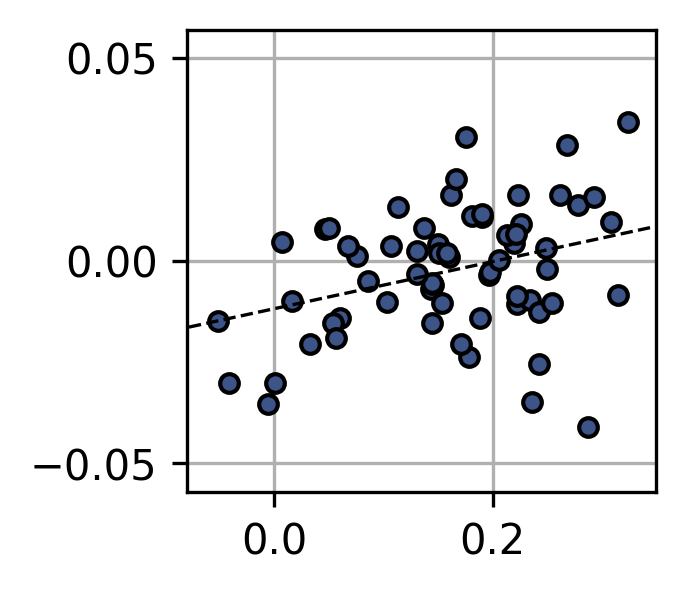

In [5]:
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(2.02, 2), dpi=300)
x = ordering_score
y = subject_rs
ax.scatter(x, y, s=20, facecolor='#3C5488', edgecolor='k', zorder=100)
slope, intercept, r, p, stderr = linregress(x, y)
print(r)
x_range = np.array([np.min(x)-1, np.max(x)+1])
ax.plot(x_range, intercept + slope * x_range, '--', label='r={:0.3f}, p={:0.3f}'.format(r, p),
         zorder=100, lw=0.8, c='k')
ax.set_xticks([0.0, 0.2])
ax.set_xlim(-0.08, 0.35)
#axes[0].set_xlim(-3.1, 2.8)
ax.set_ylim(-0.057, 0.057)
ax.set_yticks([-0.05, 0.0, 0.05])
ax.grid(True,zorder=0)

#axes[1].yaxis.tick_right()